In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
import gc
import os
import matplotlib.pyplot as plt
import seaborn as sns 
import lightgbm as lgb
import itertools
import pickle, gzip
import glob
from sklearn.preprocessing import StandardScaler
from tsfresh.feature_extraction import extract_features
np.warnings.filterwarnings('ignore')
import dask.dataframe as dd
import missingno as msno
from pandasql import sqldf
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import KFold
import matplotlib.gridspec as gridspec
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

In [2]:
#Always seed the randomness of this universe
np.random.seed(51)

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
%%time
train_metadata_kaggle = dd.read_csv('mydata_train_metadata.csv')
test_metadata_kaggle = dd.read_csv('mydata_test_metadata.csv')
train_metadata_kaggle = train_metadata_kaggle.compute()
test_metadata_kaggle = test_metadata_kaggle.compute()
print(train_metadata_kaggle.shape,test_metadata_kaggle.shape)

(7848, 97) (3492890, 96)
CPU times: user 2min 23s, sys: 7.85 s, total: 2min 31s
Wall time: 26.1 s


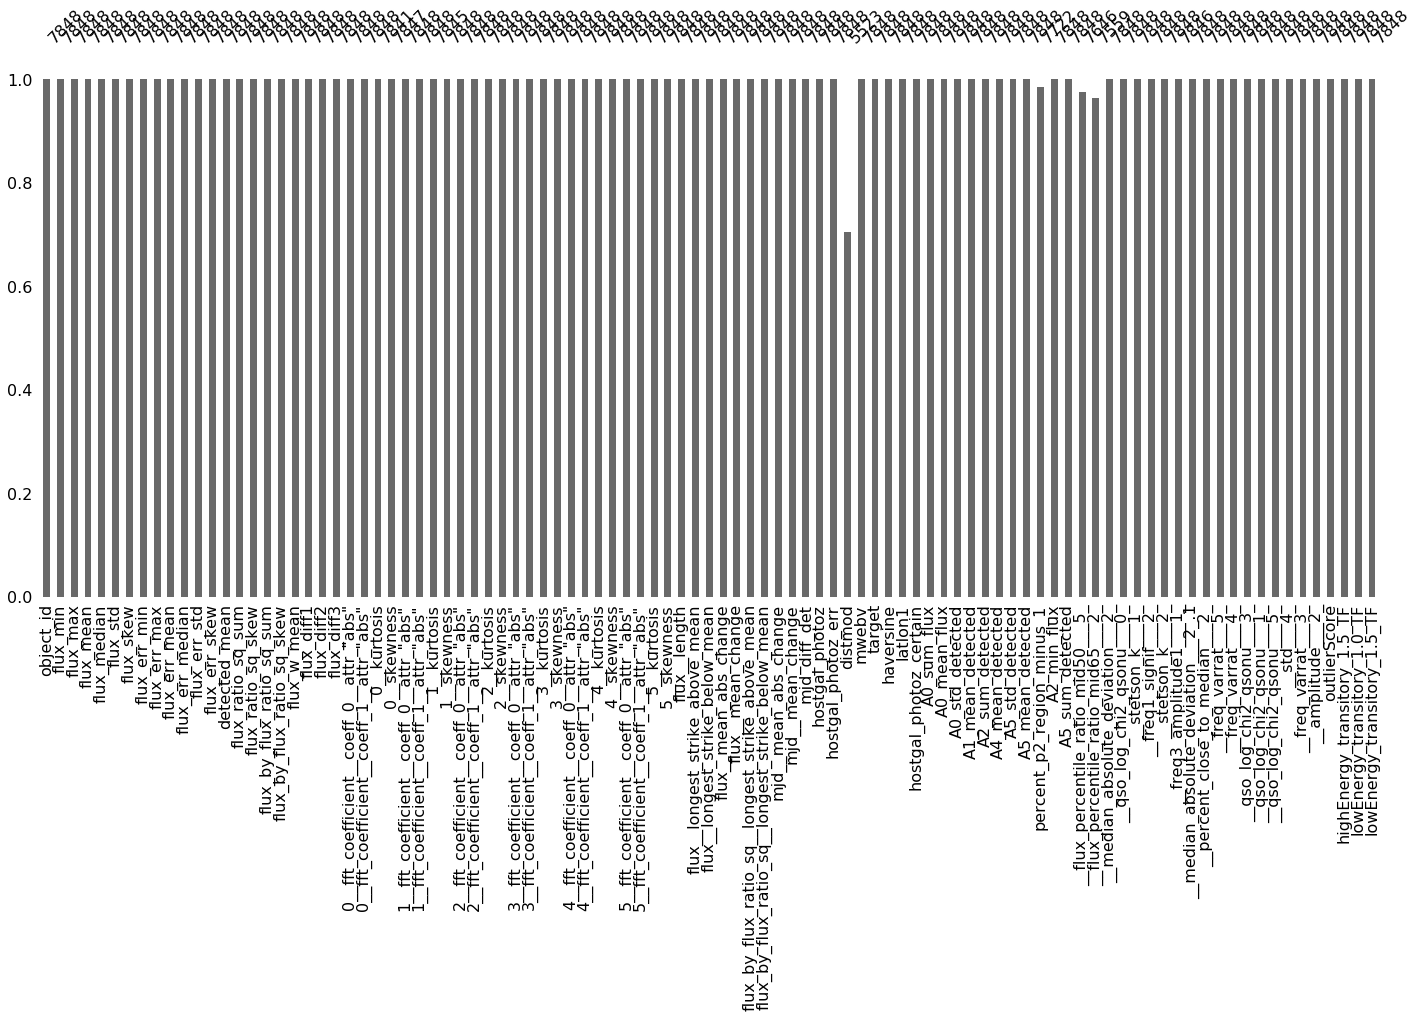

In [5]:
msno.bar(train_metadata_kaggle)

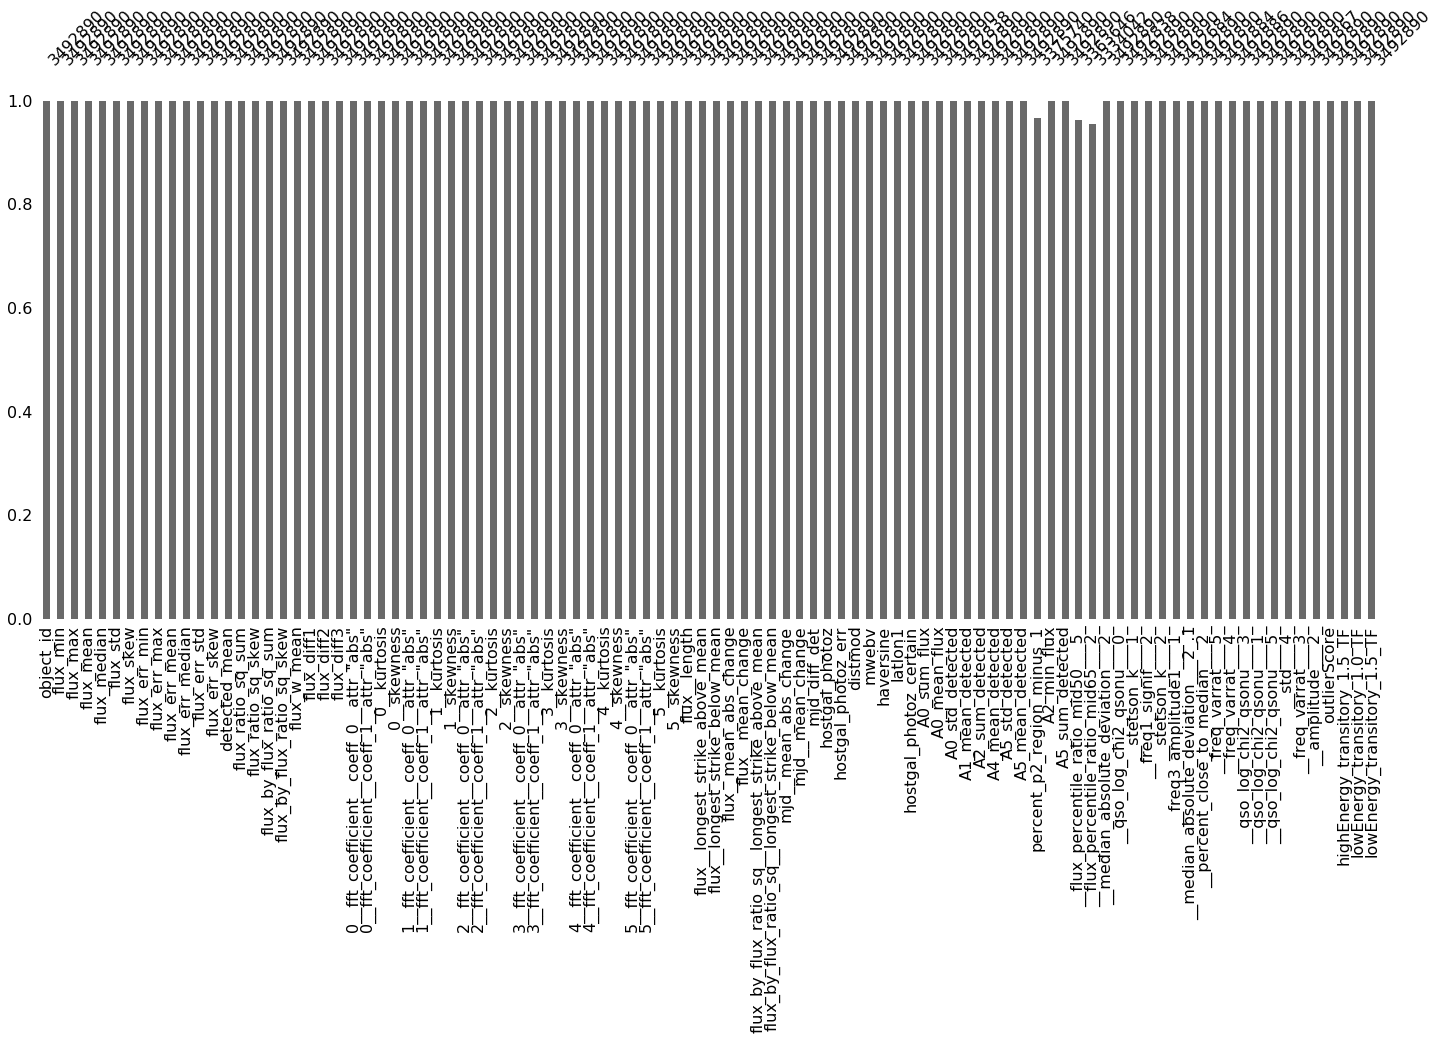

In [6]:
msno.bar(test_metadata_kaggle)

In [7]:
test_id = test_metadata_kaggle['object_id']

In [8]:
def multi_weighted_logloss(y_true, y_preds):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    # class_weights taken from Giba's topic : https://www.kaggle.com/titericz
    # https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
    # with Kyle Boone's post https://www.kaggle.com/kyleboone
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    if len(np.unique(y_true)) > 14:
        classes.append(99)
        class_weight[99] = 2
    y_p = y_preds
    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true)
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = - np.sum(y_w) / np.sum(class_arr)
    return loss


def lgb_multi_weighted_logloss(y_true, y_preds):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    # class_weights taken from Giba's topic : https://www.kaggle.com/titericz
    # https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
    # with Kyle Boone's post https://www.kaggle.com/kyleboone
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    if len(np.unique(y_true)) > 14:
        classes.append(99)
        class_weight[99] = 2
    y_p = y_preds.reshape(y_true.shape[0], len(classes), order='F')

    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true)
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = - np.sum(y_w) / np.sum(class_arr)
    return 'wloss', loss, False

In [9]:
%%time
final_dict = {}

loss_list = []
temp = train_metadata_kaggle.copy()
#temp = temp.merge(train_metadata[['object_id',column_]],on = 'object_id',how = 'left')
y = temp['target']
del temp['target']
classes = sorted(y.unique())

# Taken from Giba's topic : https://www.kaggle.com/titericz
# https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
# with Kyle Boone's post https://www.kaggle.com/kyleboone
class_weight = {
    c: 1 for c in classes
}
for c in [64, 15]:
    class_weight[c] = 2

#print('Unique classes : ', classes)

train_id = temp['object_id']
del temp['object_id']
# Compute weights
w = y.value_counts()
weights = {i : np.sum(w) / w[i] for i in w.index}
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=51)
clfs = []
importances = pd.DataFrame()
lgb_params = {
'random_state':51,
'device': 'cpu', 
'objective': 'multiclass', 
'num_class': 14, 
'boosting_type': 'gbdt', 
'n_jobs': -1, 
'max_depth': 7, 
'n_estimators': 1000, 
'subsample_freq': 2, 
'subsample_for_bin': 5000, 
'min_data_per_group': 100, 
'max_cat_to_onehot': 4, 
'cat_l2': 1.0, 
'cat_smooth': 59.5, 
'max_cat_threshold': 32, 
'metric_freq': 10, 
'verbosity': -1, 
'metric': 'multi_logloss', 
'xgboost_dart_mode': False, 
'uniform_drop': False, 
'colsample_bytree': 0.5, 
'drop_rate': 0.173, 
'learning_rate': 0.0267, 
'max_drop': 5, 
'min_child_samples': 10, 
'min_child_weight': 100.0, 
'min_split_gain': 0.1, 
'num_leaves': 7, 
'reg_alpha': 0.1, 
'reg_lambda': 0.00023, 
'skip_drop': 0.44, 
'subsample': 0.75}
oof_preds = np.zeros((len(temp), np.unique(y).shape[0]))
for fold_, (trn_, val_) in enumerate(folds.split(y, y)):
    trn_x, trn_y = temp.iloc[trn_], y.iloc[trn_]
    val_x, val_y = temp.iloc[val_], y.iloc[val_]

    clf = lgb.LGBMClassifier(**lgb_params)
    clf.fit(
        trn_x, trn_y,
        eval_set=[(trn_x, trn_y), (val_x, val_y)],
        eval_metric=lgb_multi_weighted_logloss,
        verbose=False,
        early_stopping_rounds=50,
        sample_weight=trn_y.map(weights)
    )
    oof_preds[val_, :] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)
    loss_oof = multi_weighted_logloss(val_y, oof_preds[val_, :])
    #loss_list.append(loss_oof)
    print(fold_,loss_oof)

    imp_df = pd.DataFrame()
    imp_df['feature'] = temp.columns
    imp_df['gain'] = clf.feature_importances_
    imp_df['fold'] = fold_ + 1
    importances = pd.concat([importances, imp_df], axis=0, sort=False)

    clfs.append(clf)
print('MULTI WEIGHTED LOG LOSS : %.5f ' % multi_weighted_logloss(y_true=y, y_preds=oof_preds))
#final_dict[column_] = loss_list

0 0.6316324136021252
1 0.5974384829934377
2 0.6560978939660322
3 0.60199520197639
4 0.6051021258382633
MULTI WEIGHTED LOG LOSS : 0.61858 
CPU times: user 8min 10s, sys: 1.2 s, total: 8min 12s
Wall time: 1min 3s


In [10]:
#modify to work with kfold
#def smoteAdataset(Xig, yig, test_size=0.2, random_state=0):
def smoteAdataset(Xig_train, yig_train, Xig_test, yig_test):
    
        
    sm=SMOTE(random_state=51)
    Xig_train_res, yig_train_res = sm.fit_sample(Xig_train, yig_train.ravel())

        
    return Xig_train_res, pd.Series(yig_train_res), Xig_test, pd.Series(yig_test)

In [11]:
%%time
final_dict = {}

loss_list = []
temp = train_metadata_kaggle.copy()
#temp.fillna(0, inplace=True)
#temp = temp.merge(train_metadata[['object_id',column_]],on = 'object_id',how = 'left')
y = temp['target']
del temp['target']
classes = sorted(y.unique())

# Taken from Giba's topic : https://www.kaggle.com/titericz
# https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
# with Kyle Boone's post https://www.kaggle.com/kyleboone
class_weight = {
    c: 1 for c in classes
}
for c in [64, 15]:
    class_weight[c] = 2

#print('Unique classes : ', classes)

train_id = temp['object_id']
del temp['object_id']
# Compute weights
w = y.value_counts()
weights = {i : np.sum(w) / w[i] for i in w.index}
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=51)
clfs = []
importances = pd.DataFrame()
lgb_params = {
'random_state':51,
'device': 'cpu', 
'objective': 'multiclass', 
'num_class': 14, 
'boosting_type': 'gbdt', 
'n_jobs': -1, 
'max_depth': 7, 
'n_estimators': 1000, 
'subsample_freq': 2, 
'subsample_for_bin': 5000, 
'min_data_per_group': 100, 
'max_cat_to_onehot': 4, 
'cat_l2': 1.0, 
'cat_smooth': 59.5, 
'max_cat_threshold': 32, 
'metric_freq': 10, 
'verbosity': -1, 
'metric': 'multi_logloss', 
'xgboost_dart_mode': False, 
'uniform_drop': False, 
'colsample_bytree': 0.5, 
'drop_rate': 0.173, 
'learning_rate': 0.0267, 
'max_drop': 5, 
'min_child_samples': 10, 
'min_child_weight': 100.0, 
'min_split_gain': 0.1, 
'num_leaves': 7, 
'reg_alpha': 0.1, 
'reg_lambda': 0.00023, 
'skip_drop': 0.44, 
'subsample': 0.75}
oof_preds = np.zeros((len(temp), np.unique(y).shape[0]))
for fold_, (trn_, val_) in enumerate(folds.split(y, y)):
    trn_x, trn_y = temp.iloc[trn_], y.iloc[trn_]
    val_x, val_y = temp.iloc[val_], y.iloc[val_]

    #trn_xa, trn_y, val_xa, val_y=smoteAdataset(trn_x.values, trn_y.values, val_x.values, val_y.values)
    #trn_x=pd.DataFrame(data=trn_xa, columns=trn_x.columns)
    #val_x=pd.DataFrame(data=val_xa, columns=val_x.columns)
    
    print(trn_x.shape,trn_y.shape,val_x.shape,val_y.shape)
    
    clf = lgb.LGBMClassifier(**lgb_params)
    clf.fit(
        trn_x, trn_y,
        eval_set=[(trn_x, trn_y), (val_x, val_y)],
        eval_metric=lgb_multi_weighted_logloss,
        verbose=False,
        early_stopping_rounds=50,
        sample_weight=trn_y.map(weights)
    )
    oof_preds[val_, :] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)
    loss_oof = multi_weighted_logloss(val_y, oof_preds[val_, :])
    #loss_list.append(loss_oof)
    print(fold_,loss_oof)

    imp_df = pd.DataFrame()
    imp_df['feature'] = temp.columns
    imp_df['gain'] = clf.feature_importances_
    imp_df['fold'] = fold_ + 1
    importances = pd.concat([importances, imp_df], axis=0, sort=False)

    clfs.append(clf)
print('MULTI WEIGHTED LOG LOSS : %.5f ' % multi_weighted_logloss(y_true=y, y_preds=oof_preds))
#final_dict[column_] = loss_list

(6274, 95) (6274,) (1574, 95) (1574,)
0 0.6316324136021252
(6276, 95) (6276,) (1572, 95) (1572,)
1 0.5974384829934377
(6277, 95) (6277,) (1571, 95) (1571,)
2 0.6560978939660322
(6281, 95) (6281,) (1567, 95) (1567,)
3 0.60199520197639
(6284, 95) (6284,) (1564, 95) (1564,)
4 0.6051021258382633
MULTI WEIGHTED LOG LOSS : 0.61858 
CPU times: user 8min 14s, sys: 1.16 s, total: 8min 15s
Wall time: 1min 3s


In [12]:
temp_test = test_metadata_kaggle.copy()

In [13]:
del temp_test['object_id']

In [14]:
#temp_test.fillna(0.0,inplace = True)

In [15]:
print(temp.shape,temp_test.shape)

(7848, 95) (3492890, 95)


In [16]:
list(temp.columns) == list(temp_test.columns)

True

In [17]:
%%time
test_pred0 = pd.DataFrame()
test_pred1 = pd.DataFrame()
test_pred2 = pd.DataFrame()
test_pred3 = pd.DataFrame()
test_pred4 = pd.DataFrame()

list_of_df = [test_pred0,test_pred1,test_pred2,test_pred3,test_pred4]

for num,c in enumerate(clfs):
    print(num)
    for k in range(0,len(temp_test),500000):
        test_pred = pd.DataFrame(c.predict_proba(temp_test[ k:k+500000] ))
        list_of_df[num] = pd.concat([list_of_df[num],test_pred],axis=0)
        del test_pred

0
1
2
3
4
CPU times: user 2h 14min 28s, sys: 29.6 s, total: 2h 14min 57s
Wall time: 18min 41s


In [18]:
test_pred2 = pd.DataFrame()
test_pred2 = (list_of_df[0] + list_of_df[1] + list_of_df[2] + list_of_df[3] + list_of_df[4])/5

In [19]:
print(test_pred2.shape)

(3492890, 14)


In [20]:
test_pred2[14] = 0.15

In [21]:
test_pred2 = test_pred2 / 1.15

In [22]:
test_pred2 = test_pred2.reset_index(drop=True)

In [23]:
temp_columns = ['object_id','class_6','class_15','class_16','class_42','class_52','class_53','class_62','class_64','class_65','class_67','class_88','class_90','class_92','class_95','class_99']

In [24]:
test_pred2.columns = temp_columns[1:]

In [25]:
print(test_pred2.shape,test_id.shape)

(3492890, 15) (3492890,)


In [26]:
test_id.tail()

43036    130787966
43037    130787971
43038    130787974
43039    130788053
43040    130788054
Name: object_id, dtype: int64

In [27]:
test_id = test_id.reset_index(drop=True)

In [28]:
test_id.index == test_pred2.index

array([ True,  True,  True, ...,  True,  True,  True])

In [29]:
%%time
test_pred = pd.concat([test_id,test_pred2],axis=1)

CPU times: user 63 ms, sys: 162 ms, total: 225 ms
Wall time: 224 ms


In [30]:
test_pred = test_pred[temp_columns]

In [31]:
test_pred.head()

,object_id,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95,class_99
0,13,0.000426,0.002543,0.000293,0.518645,0.183049,0.000795,0.078009,0.000206,0.000297,0.002618,0.000479,0.080550,0.000305,0.001350,0.130435
1,14,0.000776,0.014622,0.000691,0.170237,0.032237,0.001588,0.077401,0.000986,0.001945,0.029382,0.004428,0.524806,0.000638,0.009828,0.130435
2,17,0.000459,0.006252,0.000436,0.055991,0.020484,0.000867,0.031095,0.001881,0.000838,0.063001,0.004434,0.674644,0.000325,0.008858,0.130435
3,23,0.000470,0.002645,0.000425,0.050669,0.010553,0.000806,0.052099,0.002115,0.000617,0.215737,0.001523,0.513047,0.000293,0.018565,0.130435
4,34,0.000306,0.003350,0.000235,0.083864,0.194162,0.000599,0.041035,0.000269,0.000420,0.026701,0.000392,0.517562,0.000224,0.000447,0.130435


In [32]:
print(test_pred.shape)

(3492890, 16)


In [33]:
%%time
test_pred.to_csv('test_pred_16.csv',index=False)

CPU times: user 1min 26s, sys: 1.79 s, total: 1min 28s
Wall time: 1min 28s
